In [1]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

# Stochastic Volatility: Heston Model

Comprises of two SDEs:
$$\text{Asset:} \hspace{10pt} dS = \mu Sdt + \sqrt{v(t)}S dZ_1$$
$$\text{Variance:} \hspace{10pt} dv(t) = \kappa \left( \theta - v(t) \right) dt + \sigma \sqrt{v(t)} dZ_2$$
where 

- $dZ_1$ and $dZ_2$ are Wiener processes with correlation $\rho$.
- $\theta$ - long run average variance.
- $\kappa$ - rate of mean-reversion.
- $\sigma$ - vol of vol

Can simulate Heston under Monte-Carlo methods:
$$S_t = S_{t-1} e^{(r-\frac{v_t}{2})dt + \sigma \sqrt{v_t}dZ_1}$$
$$v_t = v_{t-1} + \kappa (\theta - v_{t-1})dt + \sigma \sqrt{v_{t-1}}dZ_2$$

In [2]:
# Stochastic volatility function: v_t
def SDE_vol(v0, kappa, theta, sigma, T, M, I, rand, row, cho_matrix, seed):
    np.random.seed(seed)
    dt = T/M # T-maturity; M-No. of time steps
    v = np.zeros((M+1, I), dtype=float)
    v[0] = v0 #Initial vol

    for t in range(1, M+1):
        ran = np.dot(cho_matrix, rand[:, t])
        dz2 = ran[row]* np.sqrt(dt) #Wiener process
        v_cal = v[t-1] + kappa*(theta - v[t-1])*dt + sigma*np.sqrt(v[t-1])*dz2 
        v[t] = np.maximum(v_cal, 0) #negative variance does'nt make sense!
    return v

In [3]:
# Stochastic equation: S_t
def Heston_paths(S0, r, v, row, cho_matrix, seed):
    np.random.seed(seed)
    S = np.zeros((M+1, I), dtype=float)
    S[0] = S0 #Initial underlying price

    for t in range(1, M+1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        dz1 = ran[row]* np.sqrt(dt) #Wiener process
        #There should be sigma? (replace 1)
        S[t] = S[t-1]*np.exp((r-0.5*v[t-1])*dt + 1*np.sqrt(v[t-1])*dz1)
    return S

In [4]:
# Random number generator from N(0,1)
def random_number_gen(M, I, seed):
    np.random.seed(seed)
    rand = np.random.standard_normal((2, M+1, I))
    return rand

In [5]:
# Plot function
def plot_paths(n):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    #ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")

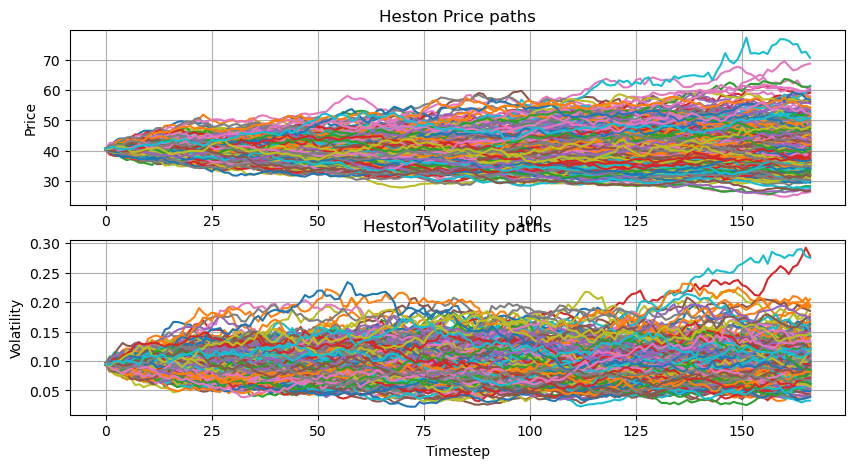

In [14]:
# Ex1
## Parameters
v0 = 0.032
kappa_v = 1.85
sigma_v = 0.35
theta_v = 0.045
rho = -0.3

S0 = 40.53  # Current underlying asset price
r = 0.085  # Risk-free rate
M0 = 500   # Number of time steps in a year
T = 4/12  # Number of years
t=0
M = int(M0*T) # Total time steps
I = 20000  # Number of simulations
dt = T/M  # Length of time step
seed = 42 # Set random seed

## Generating random numbers
rand = random_number_gen(M, I, seed)

## Covariance Matrix (Cholesky decomposition for correlation between dZ_1 and dZ_2)
covariance_matrix = np.zeros((2, 2))
covariance_matrix[0] = [1, rho]
covariance_matrix[1] = [rho, 1]
cho_matrix = np.linalg.cholesky(covariance_matrix)

## Generate paths for both asset price and its volatility
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand, 1, cho_matrix, seed)
S = Heston_paths(S0, r, V, 0, cho_matrix, seed)

# Plot paths
plot_paths(300)

### Statistical Distribution of Heston Model

Heston model produces returns with heavier tails and kurtosis than a normal distribution. Below assesses:

- Whether underlying returns resemble Normal distribution.
    
- How volatility fits a mean-reverting process such as CIR or Vasicek

Text(0.5, 0, 'Log-returns')

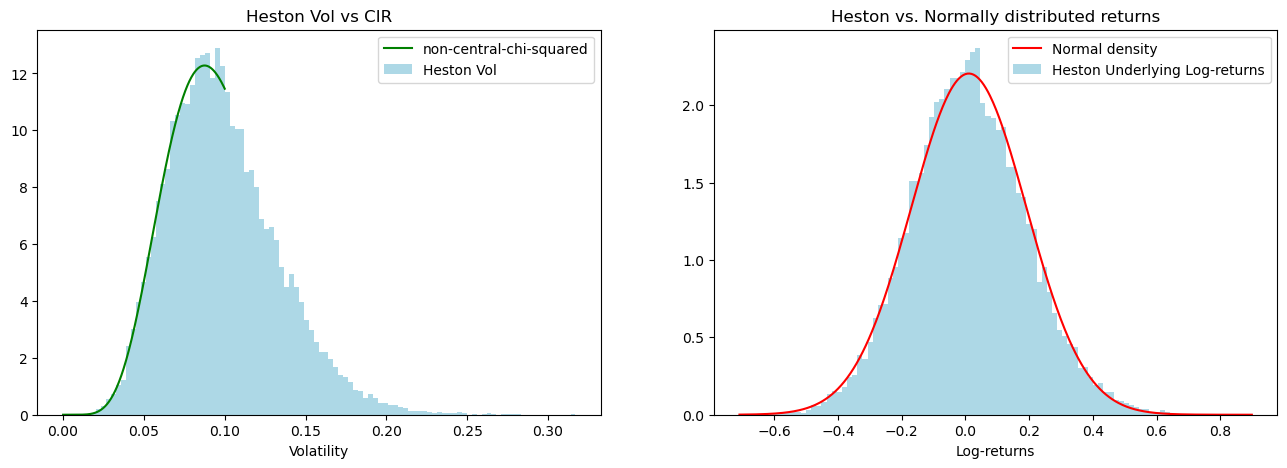

In [12]:
# Obtaining degrees of freedom 
c = 2 * kappa_v / ((1 - np.exp(-kappa_v * T)) * sigma_v**2)
df = 4 * kappa_v * theta_v / sigma_v**2
nc = 2 * c * v0 * np.exp(-kappa_v * T)

# Calculating returns and lengths of axis
log_R = np.log(S[-1, :] / S0)
x = np.linspace(log_R.min(), log_R.max(), 500)
y = np.linspace(0.00001, 0.1, 500)

## Plot distributions
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# 1) Heston stochastic vol follows a CIR/Vasicek process
ax1.plot(y, ss.ncx2.pdf(y, df, nc, scale=1 / (2 * c)),
    color="green", label="non-central-chi-squared",)
ax1.hist(V[-1, :], density=True, bins=100, facecolor="LightBlue", label="Heston Vol")
ax1.legend()
ax1.set_title("Heston Vol vs CIR")
ax1.set_xlabel("Volatility")

# 2) Heston underlying returns do not follow a normal distribution
ax2.plot(x, ss.norm.pdf(x, log_R.mean(), log_R.std(ddof=0)),
    color="r", label="Normal density",)
ax2.hist(log_R, density=True, bins=100,
    facecolor="LightBlue", label="Heston Underlying Log-returns",)
ax2.legend()
ax2.set_title("Heston vs. Normally distributed returns")
ax2.set_xlabel("Log-returns")

Now calculate payoffs and current price of a European call option with:
- T = 1 year
- K = 90
- r = 0.05
- $S_t \sim$ Heston dynamics  

In [15]:
def heston_opt_mc(S, K, r, T, t, opttyp):
    if opttyp == "C":
        payoff = np.maximum(S[-1, :] - K, 0) 
    else:
        payoff = np.maximum(K - S[-1, :], 0)
    
    return np.exp(-r*(T - t)) * np.mean(payoff)

In [16]:
print("European Call Price under Heston: ", heston_opt_mc(S, 39, r, T, t, "C"))

European Call Price under Heston:  4.276538323063399


Compare Heston option price to Black-Scholes framework

In [17]:
# BS closed-form solution
def bs_opt_price(S, r, sigma, t, T, K, opttyp):
    ttm = T - t #Time to maturity

    #Return Payoff
    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        if opttyp == "C":
            return np.maximum(S - K, 0.0) # Call Payoff
        else:
            return np.maximum(K - S, 0.0) # Put Payoff

    vol = sigma * np.sqrt(ttm)

    #d2
    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol

    #d1
    d_plus = d_minus + vol

    if opttyp == "C":
        res = S * ss.norm.cdf(d_plus)
        res -= K * np.exp(-r * ttm) * ss.norm.cdf(d_minus)
    else:
        res = K * np.exp(-r * ttm) * norm.cdf(-d_minus)
        res -= S * norm.cdf(-d_plus)

    return res

In [18]:
print("European Call Price under BS: ", bs_opt_price(100, 0.05, sigma_v, 0, 1, 90, "C"))

European Call Price under BS:  21.321119360546376


In [19]:
# BS Monte-Carlo price
def bs_opt_mc(S, K, r, sigma, T, t, Ite, opttyp):
    data = np.zeros((Ite, 2))
    z = np.random.normal(0, 1, [1, Ite])

    # Stock price
    ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)

    if opttyp == "C":
        data[:, 1] = ST - K
    else:
        data[:, 1] = K - ST

    average = np.sum(np.amax(data, axis=1)) / float(Ite)

    return np.exp(-r * (T - t)) * average

In [21]:
print("European Call Price under BS (MC): ",
    bs_opt_mc(100, 90, 0.05, sigma_v, 1, 0, 10000, "C"),)

European Call Price under BS (MC):  21.6537562455208


# Stochastic Volatility: Merton Model

Implement Merton (1976) jump diffusion model using Monte Carlo methods. Merton model has SDE:
$$dS_t = (r - r_j) S_t dt + \sigma S_t dZ_t + J_t S_t d N_t$$

Discretized form is,
$$S_t = S_{t-1} \left( e^{[r-r_j-\frac{\sigma^2}{2}]dt + \sigma \sqrt{dt}z^1_t} + \left[ e^{\mu_j + \delta z^2_t} -1 \right]y_t \right)$$
where $z^1_t$ and $z^2_t$ follows $N(0,1)$ and $y_t \sim $ Poisson.

$$r_j = \lambda \left( e^{\mu_j + \frac{\delta^2}{2}} \right)-1$$

In [60]:
def merton_mc(S0, lamb, mu, delta, T, M, I, seed):
    np.random.seed(seed)
    dt = T / M  # Time-step

    # Monte Carlo stock prices
    SM = np.zeros((M + 1, I))
    SM[0] = S0
    
    # r_j
    rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    
    # Random numbers
    z1 = np.random.standard_normal((M + 1, I))
    z2 = np.random.standard_normal((M + 1, I))
    y = np.random.poisson(lamb * dt, (M + 1, I))

    # Simulate stock paths under Merton SDE
    for t in range(1, M + 1):
        SMt = SM[t-1] * (np.exp((r-rj-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z1[t])
            + (np.exp(mu+delta*z2[t]) - 1)*y[t])
        # To ensure that the price never goes below zero!
        SM[t] = np.maximum(SMt, 0.00001)  

    return SM

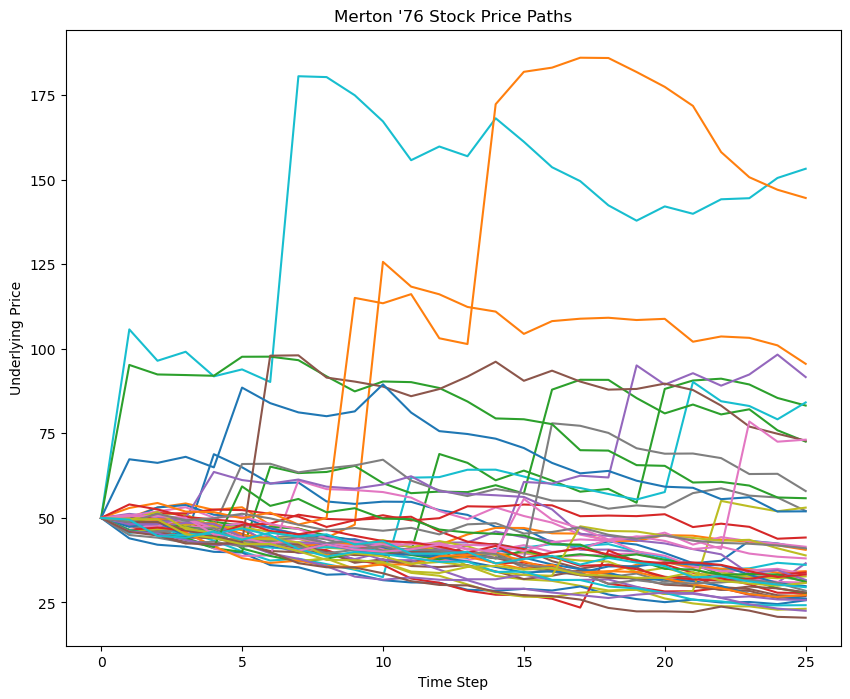

In [43]:
# Ex 2
lamb = 0.75  # Lambda of the model
mu = 0.5  # Mu
delta = 0.25  # Delta
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Maturity/time period (in years)
S0 = 50  # Current Stock Price

I = 10000  # Number of simulations (paths)
M = 25  # Number of steps

# Merton MC stock prices
SM = merton_mc(S0, lamb, mu, delta, T, M, I)

# Plot Paths
plt.figure(figsize=(10, 8))
plt.plot(SM[:, 100:150])
plt.title("Merton '76 Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

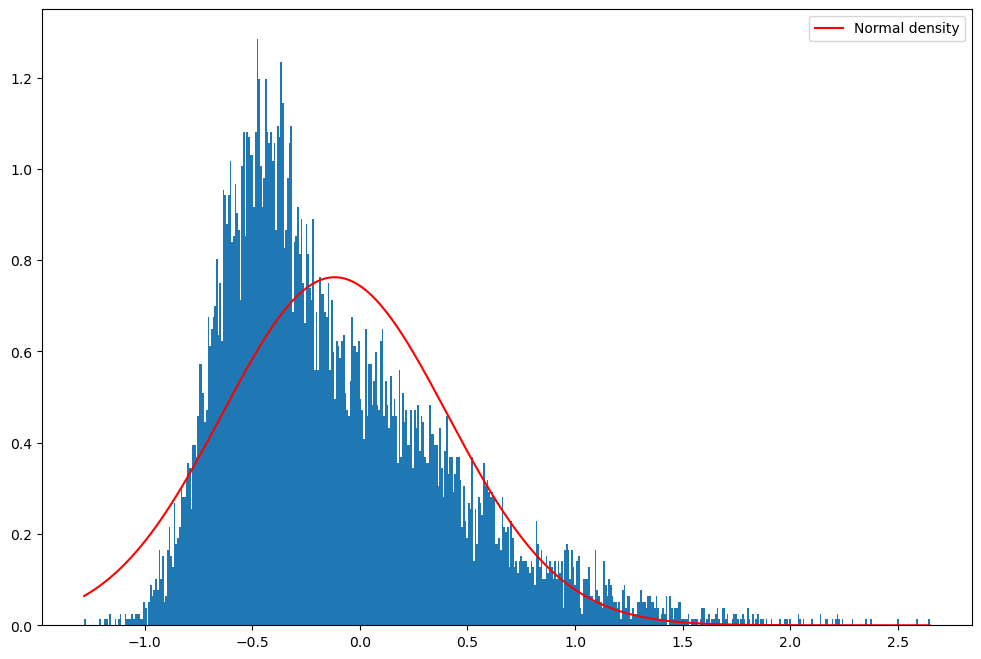

In [44]:
# Distribution of stock returns

## Calc. stock return
retSM = np.log(SM[-1, :] / S0)
x = np.linspace(retSM.min(), retSM.max(), 500)

## Plot return histogram
plt.figure(figsize=(12, 8))
plt.hist(retSM, density=True, bins=500)
plt.plot(x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color="r",
         label="Normal density")
plt.legend()
plt.show()

Implement classic Black-Scholes (GBM) and plot distribution of its returns:

In [46]:
def gbm(S0, sigma, T, M, I):
    dt = T / M  # Time-step

    # GBM stock prices
    S = np.zeros((M + 1, I))
    S[0] = S0
    
    # Simulate stock paths under Merton SDE
    for t in range(1, M + 1):
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt
        + sigma*np.sqrt(dt) * np.random.standard_normal(I)) 

    return S

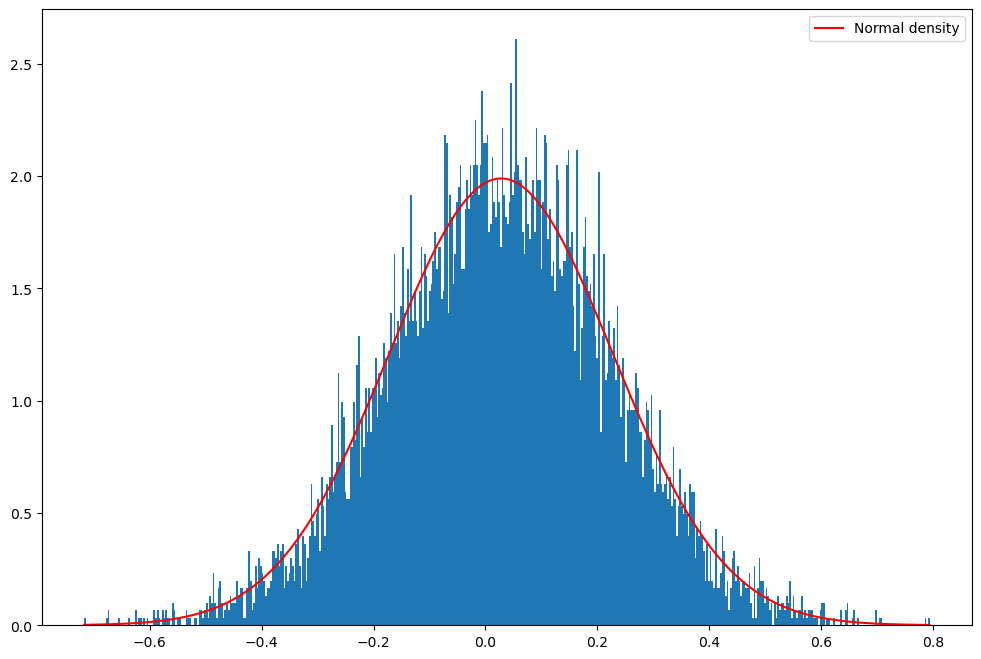

In [48]:
# Ex 3
## GBM stock price
S = gbm(S0, sigma, T, M, I)

## Calc. stock returns
retS = np.log(S[-1, :] / S0)
y = np.linspace(retS.min(), retS.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retS, density=True, bins=500)
plt.plot(y, ss.norm.pdf(y, retS.mean(), retS.std()), color="r", label="Normal density")
plt.legend()
plt.show()

Implement Heston model and plot distribution of its returns:

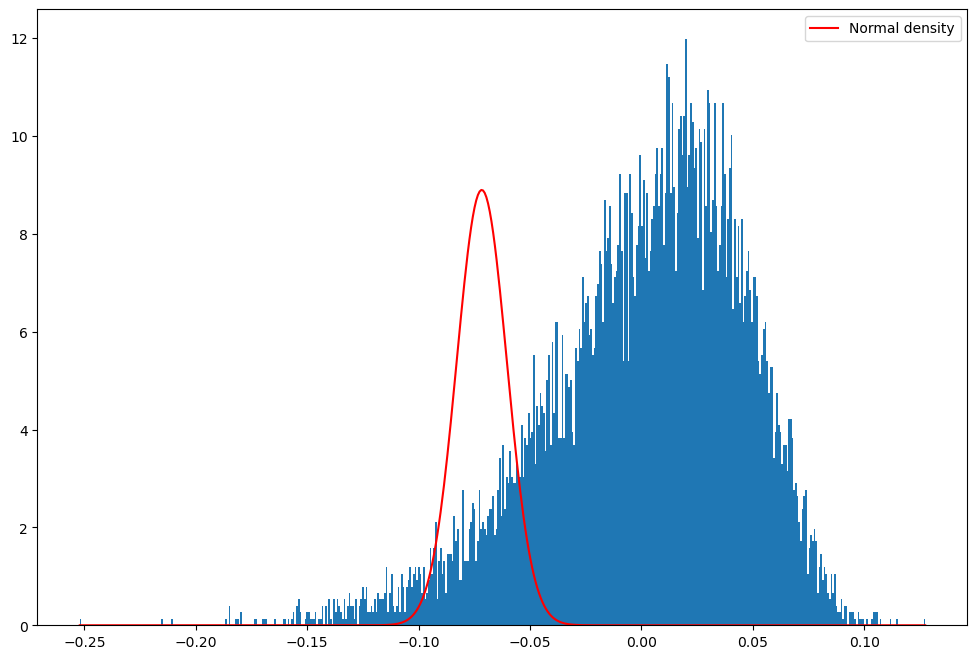

In [51]:
# Heston given parameters
v0 = 0.04
kappa_v = 2
sigma_v = 0.2
theta_v = 0.04
rho = -0.9
seed = 2

# Generating random numbers from standard normal
rand = random_number_gen(M, I, seed)

# Covariance Matrix
covariance_matrix = np.zeros((2, 2))
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand, 1, cho_matrix, seed)

# Underlying price process paths
HS = Heston_paths(S0, r, V, 0, cho_matrix, seed)

# Calc. returns
retHS = np.log(HS[-1, :] / S0)
q = np.linspace(retHS.min(), retHS.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retHS, density=True, bins=500)
plt.plot(q, ss.norm.pdf(y, retHS.mean(), retHS.std()), color="r",
         label="Normal density")
plt.legend()
plt.show()

Text(0.5, 0, 'Time Step')

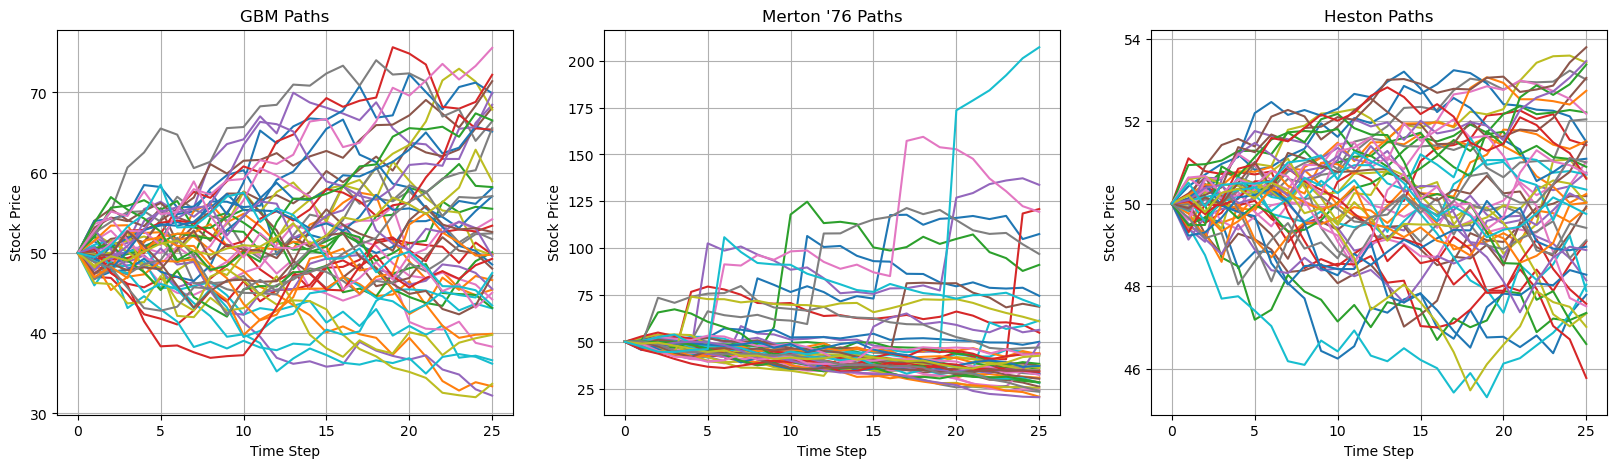

In [52]:
# Compile all 3 together
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(S[:, :50])
ax1.grid()
ax1.set_title("GBM Paths")
ax1.set_ylabel("Stock Price")
ax1.set_xlabel("Time Step")

ax2.plot(SM[:, :50])
ax2.grid()
ax2.set_title("Merton '76 Paths")
ax2.set_ylabel("Stock Price")
ax2.set_xlabel("Time Step")

ax3.plot(HS[:, :50])
ax3.grid()
ax3.set_title("Heston Paths")
ax3.set_ylabel("Stock Price")
ax3.set_xlabel("Time Step")

# Option Pricing under Different Models

### 1) Pricing under Black-Scholes (GBM)

In [55]:
# BS closed-form solution
print("European Call Price under BS (closed-form soln): ", bs_opt_price(S=S0, r=r, sigma=sigma, t=0, T=T, K=90, opttyp="C"))

# BS Monte-Carlo price
print("European Call Price under BS (MC): ", bs_opt_mc(S=S0, K=90, r=r, sigma=sigma, T=T, t=0, Ite=I, opttyp="C"))

European Call Price under BS (closed-form soln):  0.014321429058091473
European Call Price under BS (MC):  0.01465025726121158


### 2) Pricing under Heston

In [68]:
print("European Call Price under Heston: ", heston_opt_mc(S=HS, K=90, r=r, T=T, t=0, opttyp="C"))

European Call Price under Heston:  0.0


### 3) Pricing under Merton

In [57]:
def merton_opt_mc(S, K, r, T, t, opttyp):
    if opttyp == "C":
        payoff = np.maximum(0, S[-1, :] - K)
    else:
        payoff = np.maximum(0, K - S[-1, :])

    average = np.mean(payoff)
    return np.exp(-r * (T - t)) * average

In [69]:
print("European Call Price under Merton: ", merton_opt_mc(S=SM, K=90, r=r, T=T, t=0, opttyp="C"))

European Call Price under Merton:  33.62369307753957


## Merton Model Parameters

Focus on parameters:
- $\lambda$ - intensity (frequency) of the jump (shock) to stock prices.
- $\mu_j$ - average jump size (i.e. positive or negative)

NB: Actual values will come from a calibration to observed option market prices.

Changing (increasing) $\lambda$ results in differences occuring in the extreme left tail of the distribution. Thus, by increasing $\lambda$, we're influencing probability that stock price experiences more negative returns (jumps).

Changing (increasing) $\mu_j$ results in jumps being more positive. As it controls the average multiplicative jump size.

Changing (increasing) $\delta$ results in the dispersion of jump sizes, i.e. jumps become more uncertain (could be very large).